# 8 - Capacidad del modelo y control del sobreajuste

## Preparación del entorno

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, SGDClassifier
from sklearn.datasets import make_regression, make_classification

In [ ]:
# Reproducibilidad
SEED = 42
np.random.seed(SEED)

In [ ]:
# Funciones auxiliares
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_with_std(x, y_mean, y_std, label):
    plt.plot(x, y_mean, marker='o', label=label)
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2)

## 1. Diagnóstico de under/overfitting con polinomios

Generamos un **dataset sintético** con una no linealidad moderada.

Esta introducción de la no linealidad fuerza el beneficio de polinomios en el modelo de regresión.

In [ ]:
X, y = make_regression(n_samples=800, n_features=6, noise=12.0, random_state=SEED)

X = X.copy()
X[:, 0] = np.tanh(X[:, 0]) + 0.1 * X[:, 0]**2
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.25, random_state=SEED)

Se entrenan diferentes **modelos de regresión** con valores ascendentes en los **grados de los polinomios** introducidos.

Se realiza la **evaluación** de cada modelo y se almacena su **MAE** *(Mean Absolute Error)* para el análisis.

In [ ]:
degrees = [1, 2, 3, 4, 5, 6]
train_mae, val_mae = [], []
for d in degrees:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('lin', LinearRegression())
    ])
    pipe.fit(X_tr, y_tr)
    ytr_pred = pipe.predict(X_tr)
    yva_pred = pipe.predict(X_va)
    train_mae.append(mean_absolute_error(y_tr, ytr_pred))
    val_mae.append(mean_absolute_error(y_va, yva_pred))

Visualizamos la **curva de validación** para observar el rendimiento de los modelos e identificar si ocurre **overfitting** o **underfitting**.

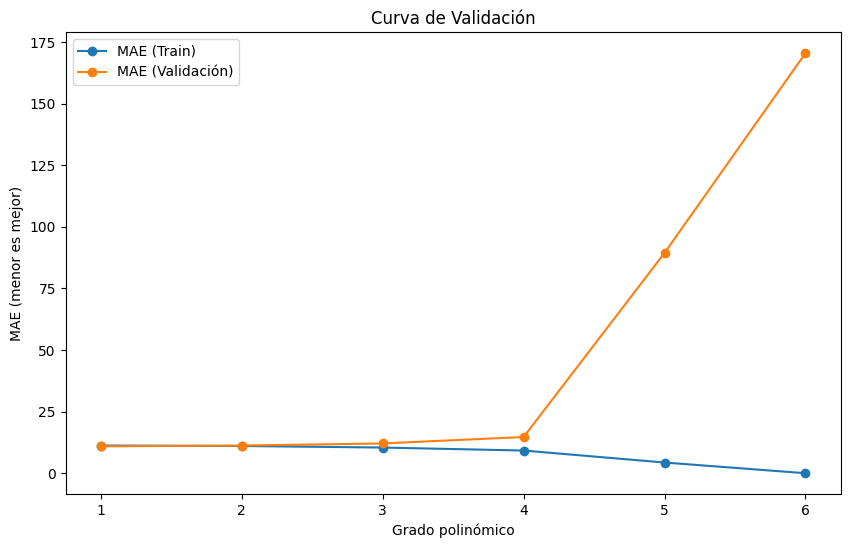

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mae, marker='o', label='MAE (Train)')
plt.plot(degrees, val_mae, marker='o', label='MAE (Validación)')
plt.xlabel('Grado polinómico')
plt.ylabel('MAE (menor es mejor)')
plt.title('Curva de Validación')
plt.legend()
plt.show()

## 2. Regularización en regresión

Se genera un **conjunto de λ** (lambda/hiperparámetro de regularización) para evaluar su efecto.

In [ ]:
alphas = np.logspace(-4, 2, 12)
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

Se define una función que **evalúe el rendimiento** de cada modelo bajo la **misma métrica y pipeline**.

In [ ]:
def cv_mae_for(model):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=4, include_bias=False)),
        ('model', model)
    ])
    scores = -cross_val_score(pipe, X, y, scoring='neg_mean_absolute_error', cv=kf)
    return scores.mean(), scores.std(ddof=1)

Se lleva a cabo el **entrenamiento** de los modelos aplicando **L1** (Lasso), **L2** (Ridge) y **Elastic Net** por cada valor de λ.

In [ ]:
ridge_means, ridge_stds = [], []
lasso_means, lasso_stds = [], []
enet_means, enet_stds = [], []
for a in alphas:
    m, s = cv_mae_for(Ridge(alpha=a))
    ridge_means.append(m); ridge_stds.append(s)
    m, s = cv_mae_for(Lasso(alpha=a, max_iter=10000))
    lasso_means.append(m); lasso_stds.append(s)
    m, s = cv_mae_for(ElasticNet(alpha=a, l1_ratio=0.5, max_iter=10000))
    enet_means.append(m); enet_stds.append(s)

Se generan las **curvas de validación** de cada método de **regularización** para observar su efecto.

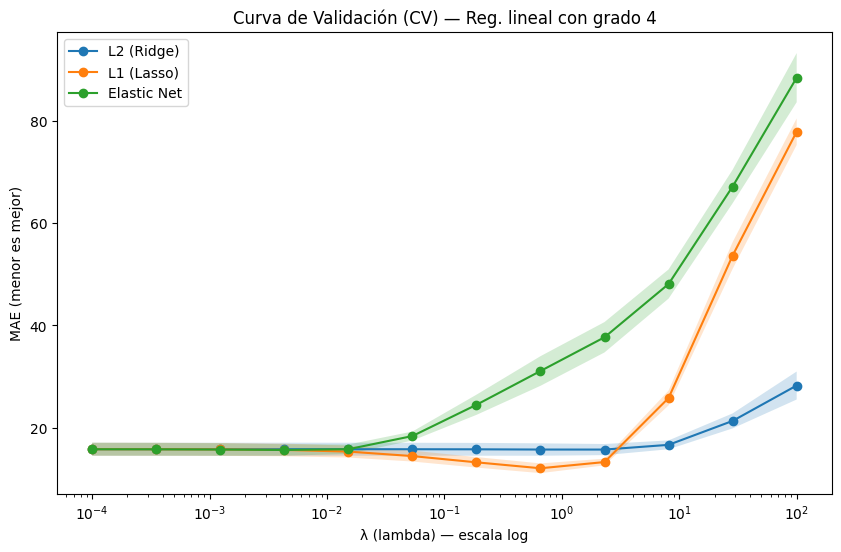

In [ ]:
plt.figure(figsize=(10, 6))
plot_with_std(alphas, np.array(ridge_means), np.array(ridge_stds), 'L2 (Ridge)')
plot_with_std(alphas, np.array(lasso_means), np.array(lasso_stds), 'L1 (Lasso)')
plot_with_std(alphas, np.array(enet_means), np.array(enet_stds), 'Elastic Net')
plt.xscale('log')
plt.xlabel('λ (lambda) — escala log')
plt.ylabel('MAE (menor es mejor)')
plt.title('Curva de Validación (CV) — Reg. lineal con grado 4')
plt.legend()
plt.show()

## 3. Regularización en clasificación

En `LogisticRegression`, el hiperparámetro de regularización es **C = 1/λ**. Buscamos C óptimo con F1 macro (o Accuracy si las clases están balanceadas).

Se genera por un lado, un **dataset de clasificación sintético** sobre el cual actuar para estudiar la regularización para clasificación; y por el otro, un **conjunto de C = 1/λ** *(hiperparámetro de regularización para clasificación)*.

In [ ]:
Xc, yc = make_classification(n_samples=1200, n_features=12, n_informative=6,
                             n_redundant=3, weights=None, flip_y=0.05, class_sep=1.0, random_state=SEED)
Xc_tr, Xc_va, yc_tr, yc_va = train_test_split(Xc, yc, test_size=0.25, random_state=SEED, stratify=yc)

Cs = np.logspace(-3, 2, 12)
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

Se crea una **función** que engloba la **evaluación de los difierentes niveles de regularización** a partir de los **valores C ya generados**, y la **generación** de los **datos** para visualizar más adelante las **curvas de validación**.

In [ ]:
def curve_for_logreg(penalty):
    train_f1, val_f1 = [], []
    for C in Cs:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(penalty=penalty, C=C,
            solver='liblinear' if penalty=='l1' else 'lbfgs', max_iter=2000))
        ])
        fold_tr, fold_va = [], []
        for tr, va in kf.split(Xc_tr, yc_tr):
            Xtr, Xva = Xc_tr[tr], Xc_tr[va]
            ytr, yva = yc_tr[tr], yc_tr[va]
            pipe.fit(Xtr, ytr)
            ytrp = pipe.predict(Xtr)
            yvap = pipe.predict(Xva)
            fold_tr.append(f1_score(ytr, ytrp))
            fold_va.append(f1_score(yva, yvap))
        train_f1.append(np.mean(fold_tr))
        val_f1.append(np.mean(fold_va))
    return np.array(train_f1), np.array(val_f1)

Se generan las **curvas de validación** de cada método de **regularización** para observar su efecto.

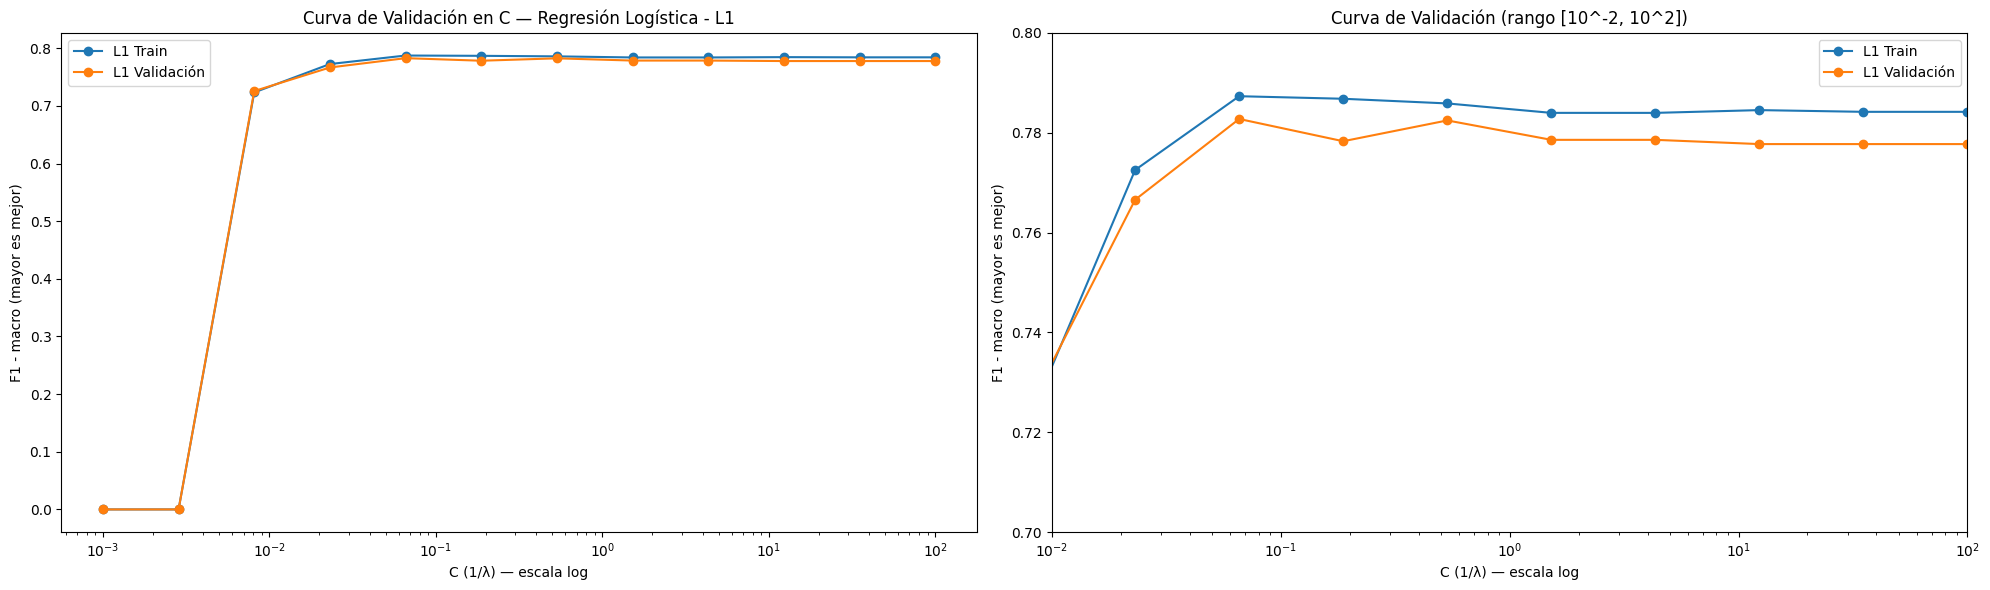

In [ ]:
train_l2, val_l2 = curve_for_logreg('l2')
train_l1, val_l1 = curve_for_logreg('l1')

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.sca(axes[0])
plot_with_std(Cs, train_l1, np.zeros_like(train_l1), 'L1 Train')
plot_with_std(Cs, val_l1, np.zeros_like(val_l1), 'L1 Validación')
plt.xscale('log')
plt.xlabel('C (1/λ) — escala log')
plt.ylabel('F1 - macro (mayor es mejor)')
plt.title('Curva de Validación en C — Regresión Logística - L1')
plt.legend()

plt.sca(axes[1])
plot_with_std(Cs, train_l1, np.zeros_like(train_l1), 'L1 Train')
plot_with_std(Cs, val_l1, np.zeros_like(val_l1), 'L1 Validación')
plt.xscale('log')
plt.xlabel('C (1/λ) — escala log')
plt.ylabel('F1 - macro (mayor es mejor)')
plt.title('Curva de Validación (rango [10^-2, 10^2])')
plt.legend()
plt.xlim([10**-2, 10**2])
plt.ylim([0.7, 0.8])

plt.tight_layout()
plt.show()

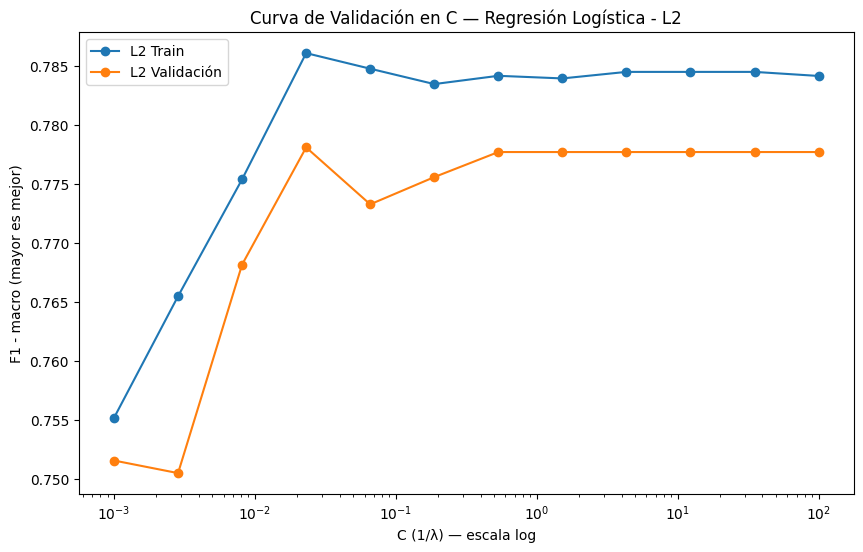

In [ ]:
plt.figure(figsize=(10, 6))
plot_with_std(Cs, train_l2, np.zeros_like(train_l2), 'L2 Train')
plot_with_std(Cs, val_l2, np.zeros_like(val_l2), 'L2 Validación')
plt.xscale('log')
plt.xlabel('C (1/λ) — escala log')
plt.ylabel('F1 - macro (mayor es mejor)')
plt.title('Curva de Validación en C — Regresión Logística - L2')
plt.legend()
plt.show()

## 4. Curvas de aprendizaje

Se calcula el **rendimiento** del modelo de **regresión** para **diferentes tamaños de entrenamiento** *(todo a partir del dataset sintético creado antes con 800 registros)*.

In [ ]:
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=1.0))])
n_train, train_scores, val_scores = learning_curve(
    ridge_pipe, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 6), random_state=SEED
)
train_mae = -train_scores
val_mae = -val_scores

Se visualiza la **curva de aprendizaje** para determinar si **más datos u otro modelo** serían **beneficiosos**.

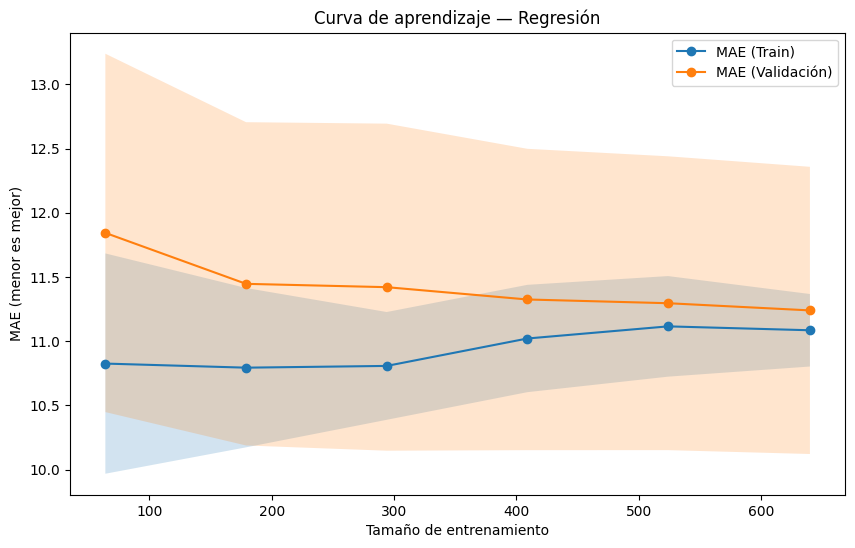

In [ ]:
plt.figure(figsize=(10, 6))
plot_with_std(n_train, train_mae.mean(axis=1), train_mae.std(axis=1, ddof=1), 'MAE (Train)')
plot_with_std(n_train, val_mae.mean(axis=1), val_mae.std(axis=1, ddof=1), 'MAE (Validación)')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('MAE (menor es mejor)')
plt.title('Curva de aprendizaje — Regresión')
plt.legend()
plt.show()

Se realizan las mismas acciones sobre el **dataset sintético de clasificación**.

In [ ]:
logreg_pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=2000))])
n_train_c, train_s_c, val_s_c = learning_curve(
    logreg_pipe, Xc, yc, cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring='f1_macro', train_sizes=np.linspace(0.1, 1.0, 6), random_state=SEED
)

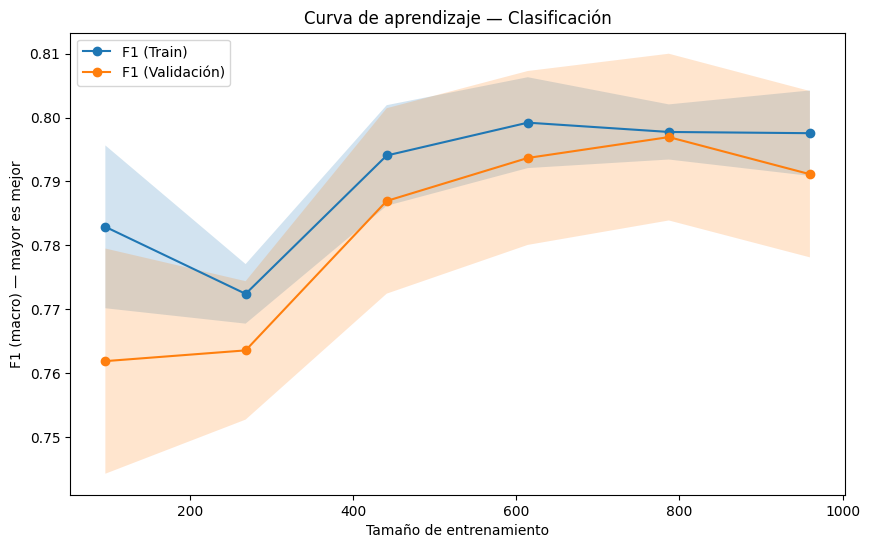

In [ ]:
plt.figure(figsize=(10, 6))
plot_with_std(n_train_c, train_s_c.mean(axis=1), train_s_c.std(axis=1, ddof=1), 'F1 (Train)')
plot_with_std(n_train_c, val_s_c.mean(axis=1), val_s_c.std(axis=1, ddof=1), 'F1 (Validación)')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('F1 (macro) — mayor es mejor')
plt.title('Curva de aprendizaje — Clasificación')
plt.legend()
plt.show()

## 5. Early stopping - ejemplo con SGD *(modelo iterativo aún no visto)*

Se crea un **dataset sintético de clasificación moderadamente ruidoso**.

In [ ]:
Xd, yd = make_classification(n_samples=2000, n_features=20, n_informative=8,
                             n_redundant=4, flip_y=0.06, class_sep=1.0, random_state=SEED)
Xd_tr, Xd_va, yd_tr, yd_va = train_test_split(Xd, yd, test_size=0.25, random_state=SEED, stratify=yd)

scaler = StandardScaler()
Xd_tr = scaler.fit_transform(Xd_tr)
Xd_va = scaler.transform(Xd_va)

Se implementa el **entrenamiento por épocas** con `SGDClassifier` y se mide el **error en validación** por época/iteración.

El proceso **para si no mejora** tras `patience` épocas.

En eso consiste el **early stopping**.

In [ ]:
# =====================================================================
# CÓDIGO PARA EL ENTRENAMIENTO DEL SGD
# (aún no hemos visto este modelo, no hay que fijarse en sus detalles,
# sino en los del early stopping)
# =====================================================================
clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-4, random_state=SEED)
classes = np.unique(yd_tr)

epochs = 80
batch_size = 128
patience = 5 # número de iteraciones sin mejora que se toleran antes de parar
best_epoch, best_val = -1, np.inf
patience_left = patience
history = {'epoch': [], 'train_logloss': [], 'val_logloss': [], 'val_acc': []}

for epoch in range(1, epochs+1):
    idx = np.random.permutation(len(Xd_tr))
    Xd_tr_sh, yd_tr_sh = Xd_tr[idx], yd_tr[idx]
    for start in range(0, len(Xd_tr_sh), batch_size):
        stop = start + batch_size
        clf.partial_fit(Xd_tr_sh[start:stop], yd_tr_sh[start:stop], classes=classes)
    p_tr = clf.predict_proba(Xd_tr)
    p_va = clf.predict_proba(Xd_va)
    tr_ll = log_loss(yd_tr, p_tr)
    va_ll = log_loss(yd_va, p_va)
    va_acc = accuracy_score(yd_va, (p_va[:,1] >= 0.5).astype(int))
    history['epoch'].append(epoch)
    history['train_logloss'].append(tr_ll)
    history['val_logloss'].append(va_ll)
    history['val_acc'].append(va_acc)

    # ¡IMPORTANTE! MECANISMO DE EARLY STOPPING:
    if va_ll < best_val:
        best_val = va_ll
        best_epoch = epoch
        patience_left = patience
    else:
        patience_left -= 1
        if patience_left == 0:
            break

Visualización de la **evolución del error** en cada epoch/iteración:

Early Stopping en epoch/iteración 25
Mejor logloss en validación: 0.8977


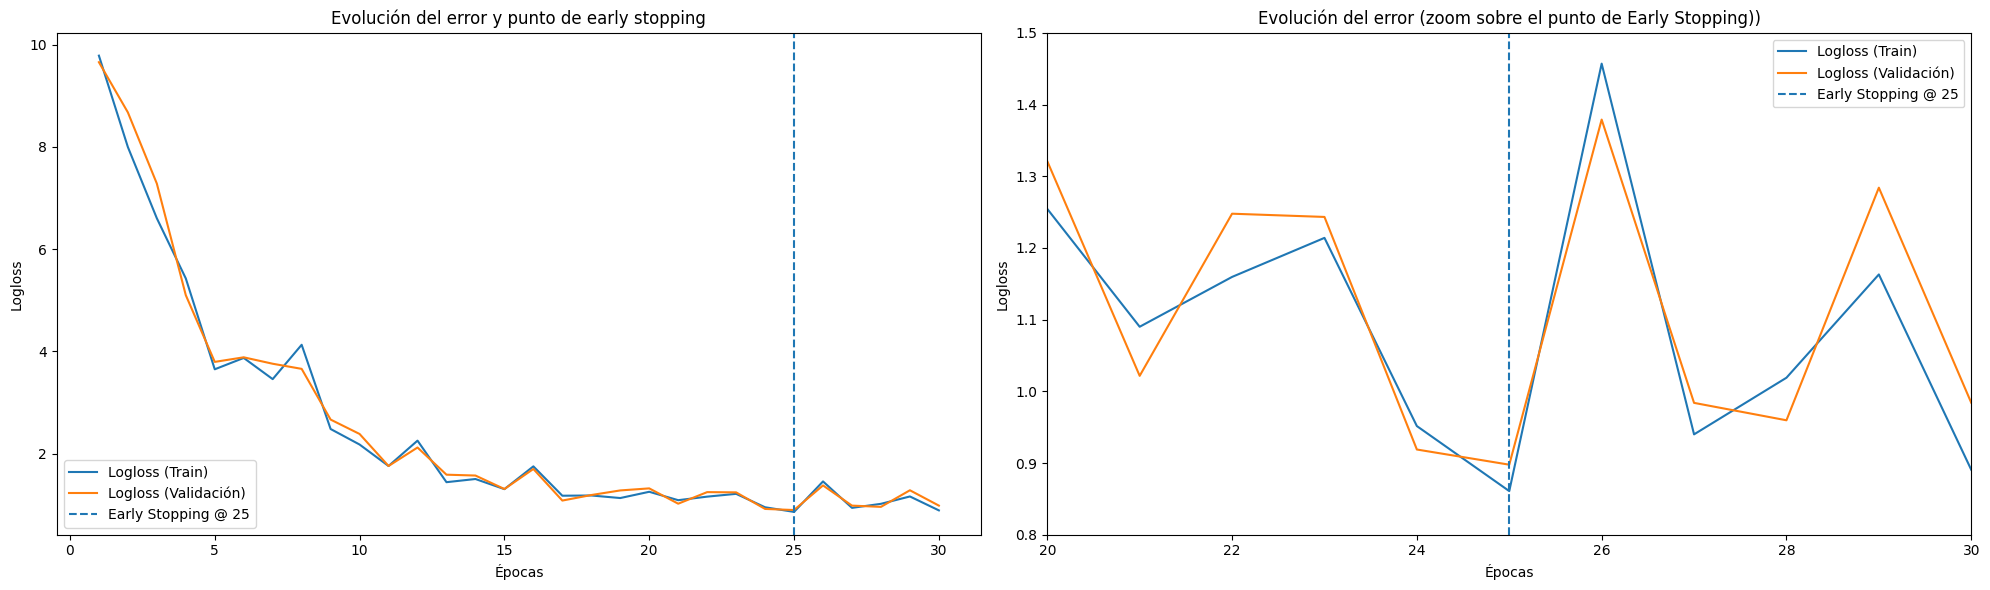

In [ ]:
epochs_seen = np.array(history['epoch'])
train_ll = np.array(history['train_logloss'])
val_ll = np.array(history['val_logloss'])
val_acc = np.array(history['val_acc'])

print(f'Early Stopping en epoch/iteración {best_epoch}')
print(f"Mejor logloss en validación: {best_val:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.sca(axes[0])
plt.plot(epochs_seen, train_ll, label='Logloss (Train)')
plt.plot(epochs_seen, val_ll, label='Logloss (Validación)')
plt.axvline(best_epoch, linestyle='--', label=f'Early Stopping @ {best_epoch}')
plt.xlabel('Épocas')
plt.ylabel('Logloss')
plt.title('Evolución del error y punto de early stopping')
plt.legend()

plt.sca(axes[1])
plt.plot(epochs_seen, train_ll, label='Logloss (Train)')
plt.plot(epochs_seen, val_ll, label='Logloss (Validación)')
plt.axvline(best_epoch, linestyle='--', label=f'Early Stopping @ {best_epoch}')
plt.xlabel('Épocas')
plt.ylabel('Logloss')
plt.title('Evolución del error (zoom sobre el punto de Early Stopping))')
plt.legend()
plt.xlim([20, 30])
plt.ylim([0.8, 1.5])

plt.tight_layout()
plt.show()

## 6. Data augmentation para datos tabulares

*Creación del dataset con "augmentation"* mediante una función gaussiana (introducción pequeñas variaciones) y **evaluación del rendimiento** en ambos casos.

In [ ]:
# Función auxiliar
def augment_gaussian(X, y, std=0.05, factor=1.0, random_state=SEED):
    rng = np.random.RandomState(random_state)
    n = int(len(X) * factor)
    idx = rng.choice(len(X), size=n, replace=True)
    X_sel, y_sel = X[idx], y[idx]
    X_aug = X_sel + rng.normal(0, std, X_sel.shape)
    return np.vstack([X, X_aug]), np.hstack([y, y_sel])

In [ ]:
pipe_log = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=2000))])
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Sin augmentation
scores_base = cross_val_score(pipe_log, Xc, yc, scoring='f1_macro', cv=cv)

# Con augmentation
Xs, ys = Xc.copy(), yc.copy()
Xs = StandardScaler().fit_transform(Xs)
Xa, ya = augment_gaussian(Xs, ys, std=0.05, factor=0.5, random_state=SEED)
pipe_aug = Pipeline([('logreg', LogisticRegression(max_iter=2000))])
scores_aug = cross_val_score(pipe_aug, Xa, ya, scoring='f1_macro', cv=cv)

print(f'F1 macro — sin augmentation: {scores_base.mean():.4f} +/- {scores_base.std(ddof=1):.4f}')
print(f'F1 macro — con augmentation: {scores_aug.mean():.4f} +/- {scores_aug.std(ddof=1):.4f}')

F1 macro — sin augmentation: 0.7911 +/- 0.0130
F1 macro — con augmentation: 0.7960 +/- 0.0184


## Ejercicio

A partir de **datasets reales** (regresión y clasificación):

1. Realiza un **diagnóstico** de underfitting y **overfitting**.
2. Prueba el **efecto** de distintos métodos de **regularización** sobre el rendimiento de modelos de regresión (lineal/logística): L1, L2, ElasticNet.
3. Genera **curvas de aprendizaje y validación** que permitan sacar conclusiones sobre el under/overfitting de los modelos.